In [ ]:
!pip install transformers[torch] datasets
!pip install accelerate -U

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt

In [ ]:
notebook_login()

In [ ]:
model_id = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


512


In [ ]:
def tokenizer_function(example):
  return tokenizer(example["text"], truncation=True)

In [ ]:
dataset = load_dataset("ppower1/instrument")['train']
dataset = dataset.shuffle(seed=42).select(range(100))
dataset = dataset.train_test_split(test_size=0.5, seed=42)
tokenized_dataset = dataset.map(tokenizer_function, batched=True)

In [ ]:
def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}

max(dataset['train'].map(count_tokens)['num_tokens'])

504

In [ ]:
training_arguments = TrainingArguments(output_dir='/temp',
                   per_device_train_batch_size=4,
                   num_train_epochs=20,
                   logging_strategy="epoch",
                   logging_first_step=True,
                   save_strategy='epoch',
                   evaluation_strategy="epoch",
                   load_best_model_at_end=False)

training_arguments.logging_first_step

True

In [ ]:
class EvaluateFirstStepCallback(TrainerCallback):
    def on_step_begin(self, args, state, control, **kwargs):
        if state.global_step == 0:
            control.should_evaluate = True
class BestModelLogger(TrainerCallback):
    def __init__(self):
        self.best_metric = float('inf')
        self.best_epoch = None

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Assuming lower metric is better; adjust logic as needed
        current_metric = metrics["eval_loss"]
        if current_metric < self.best_metric:
            self.best_metric = current_metric
            self.best_epoch = state.epoch
            print(f"New best model found at epoch {self.best_epoch} with loss {self.best_metric}")

In [ ]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model,
                  training_arguments,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  data_collator=data_collator,
                  callbacks=[EvaluateFirstStepCallback(),
                             BestModelLogger()] ) #EarlyStoppingCallback(early_stopping_patience=3)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,0.746600,0.850838
1,0.346200,0.237753
2,0.275700,0.270885
3,0.296800,0.291959
4,0.281400,0.286285
5,0.295100,0.297607
6,0.259900,0.258508
7,0.223700,0.312482
8,0.272500,0.321085
9,0.206600,0.294558


New best model found at epoch 0.07692307692307693 with loss 0.8508377075195312
New best model found at epoch 1.0 with loss 0.2377530336380005


TrainOutput(global_step=260, training_loss=0.12912246684472148, metrics={'train_runtime': 129.1681, 'train_samples_per_second': 7.742, 'train_steps_per_second': 2.013, 'total_flos': 105438357371640.0, 'train_loss': 0.12912246684472148, 'epoch': 20.0})

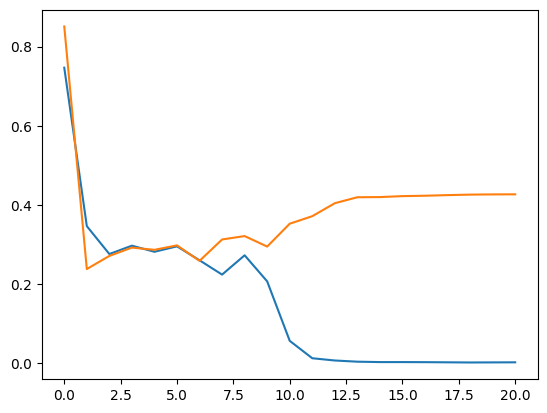

In [ ]:
training_loss = []
for i in trainer.state.log_history:
  if 'loss' in i.keys():
    training_loss.append(i['loss'])
validation_loss = []
for i in trainer.state.log_history:
  if 'eval_loss' in i.keys():
    validation_loss.append(i['eval_loss'])
import numpy as np
plt.plot(np.arange(len(training_loss)), training_loss)
plt.plot(np.arange(len(training_loss)), validation_loss)
plt.show()

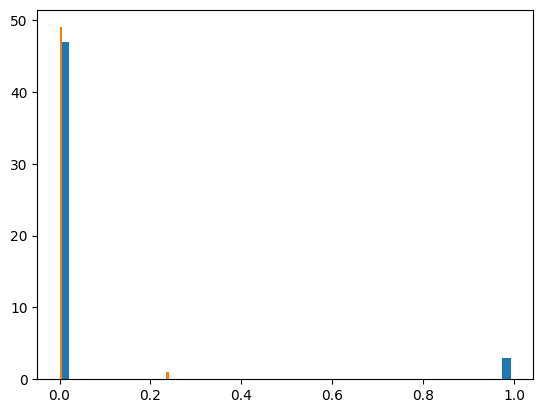

In [ ]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_dataset['train']).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()
plt.hist(original_predictions, bins=50, label='Train')
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_dataset['test']).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()
plt.hist(original_predictions, bins=50, label='Test')
plt.show()

In [ ]:
for i in range(20):
  print(original_predictions[i], dataset['train']['label'][i], dataset['test']['text'][i][:3])

0.0009102399 0 No,
0.0008585741 0 Yes
0.23973458 0 Yes
0.0009473487 0 No,
0.0009052245 0 Yes
0.0008956685 0 No,
0.0008776999 0 No,
0.0008867439 0 No,
0.0009083789 0 No,
0.00091726927 0 Yes
0.001182554 0 No,
0.0008610109 0 No,
0.0010210951 0 No,
0.005195038 0 No,
0.0009633895 0 No,
0.0008898773 0 No,
0.0008783081 0 No,
0.00090903864 1 No,
0.0012236055 0 No,
0.00093055377 0 Yes
